# How to Use

This notebook aims to be a tutorial to start using the package.
It will show how to use the package to instantiate a `Neuron` and a `Network`, and how to train them to memorize multi-channels spike trains, and how to simulate them.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

from tqdm.autonotebook import tqdm

/var/folders/p1/wl8__y5x6jgfhz_d47k5gq9m0000gn/T/ipykernel_47196/3282051363.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
%matplotlib inline

Any object can be saved to or loaded from a file using `save_object_to_file` and `load_object_from_file`.

In [3]:
from rsnn.utils.utils import save_object_to_file, load_object_from_file

We initialize the random number generator to ensure reproducibility of the results.

In [4]:
rng = np.random.RandomState(42)

## Neuron and Network

The basic unit of a spiking neural network is the spiking neuron.
To be easily identified, every neuron has an identification number.

In [5]:
from rsnn.rsnn.network import Network
from rsnn.rsnn.neuron import Neuron

Let's start by creating a `Neuron` with identification number 42. By default, a neuron has no connection and a nominal firing threshold at 1.0.

In [6]:
neuron = Neuron(42)
neuron.num_inputs, neuron.nominal_threshold

(0, 1.0)

To specify the neuron connectivity, one has to specify the three following arrays.
- `sources`: an array identifying the source neurons, on for each input.
- `delays`: an array of transmission delays, one for each input.
- `weights`: an array of synaptic weights, one for each input.

In [7]:
neuron.num_inputs = 5
neuron.sources = np.array([0, 42, 999, 123, 0]) # note that self-connections and parallel-connections are allowed
neuron.delays = np.array([1, 0.5, 10, 0.3, 6]) # the default unit of time is tau_min (the refractory period of the neuron)
neuron.weights = np.array([0.1, 0.1, -0.2, 0.2, -0.04])

assert neuron.num_inputs == neuron.sources.size == neuron.delays.size == neuron.weights.size

A `Network` is a list of `Neuron` interconnected with each other.

In [8]:
num_neurons = 200
num_inputs = 500 # number of input per neuron
neurons = [
            Neuron(
                id,
                num_inputs,
                sources=rng.choice(num_neurons, num_inputs),
                delays=rng.uniform(0.1, high=10, size=num_inputs),
                weights=rng.uniform(-0.2, high=0.2, size=num_inputs),
                )
                for id in range(num_neurons)
            ]
network = Network(neurons)

## Spike Trains

A spike train is a (sorted) `np.array` indicating the firing times all separated by at least tau_min.
From now on, we will only consider periodic spike trains, with some predefined period.
Note that such a spike train is completely identified by the list of all its firing times in window of covering an entire period.

In [9]:
from rsnn.spike_train.sampler import sample_spike_trains

In [10]:
def plot_spike_trains(spike_trains, period):
    if isinstance(spike_trains, list):
        num_channels = len(spike_trains)
    
        fig, axes = plt.subplots(num_channels, 1, figsize=(6, num_channels*0.6), sharex=True)
        
        for c in range(num_channels):
            axes[c].stem(spike_trains[c], np.ones_like(spike_trains[c]), basefmt=' ')
            axes[c].set_ylabel(f'Ch. {c}')
            axes[c].set_ylim(0, 1.8)
            axes[c].set_yticks([])
        
        axes[-1].set_xlim(0, period)
        axes[-1].set_xlabel('Time')
        return

    fig, ax = plt.subplots(1, 1, figsize=(6, 0.6))
    
    ax.stem(spike_trains, np.ones_like(spike_trains), basefmt=' ')
    ax.set_ylim(0, 1.8)
    ax.set_yticks([])
    ax.set_xlim(0, period)
    ax.set_xlabel('Time')


We start generating a (periodic) multi-channel spike train at random.

In [11]:
period = 50 # the period of the spike train
firing_rate = 0.2 # the firing rate of the spike train
spike_trains = sample_spike_trains(period, firing_rate, num_channels=num_neurons, rng=rng)

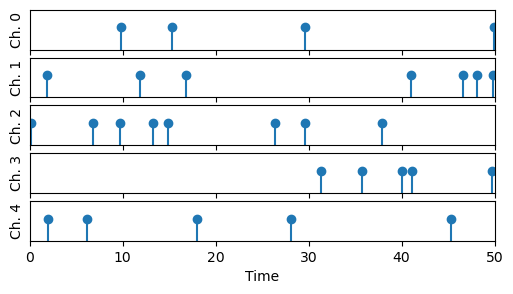

In [12]:
plot_spike_trains(spike_trains[:5], period)

## Robust Memorization

Now equipped with a network of spiking neurons and a list of (periodic) spike train (one per neuron), we can find a weights assignment to robustly store the spike train in the network.

In [13]:
# uncomment the following lines to store the spike train in the network
# for neuron in tqdm(network.neurons):
#     spike_train = spike_trains[neuron.idx]
#     input_spike_trains = [(spike_trains[s] + d).reshape(-1) for s, d in zip(neuron.sources, neuron.delays)]
#     neuron.optimize_weights(
#         spike_train, 
#         input_spike_trains, 
#         period, 
#         weight_bound=0.2,
#         weight_regularization="l2"
#         )

# save_object_to_file(network, os.path.join("data", "network.pkl"))
# save_object_to_file(spike_trains, os.path.join("data", "spike_trains.pkl"))

# uncomment the following lines to load the pretrained network and spike_trains
network = load_object_from_file(os.path.join("data", "network.pkl"))
spike_trains = load_object_from_file(os.path.join("data", "spike_trains.pkl"))

To neuron status indicates if a solution has been found. For the spike trains to be stored in the network, all neuron should be optimal.

In [14]:
if all(neuron.status == "optimal" for neuron in network.neurons):
    print("The spike trains have been successfully stored in the network.")
else:
    print("The spike trains have not been successfully stored in the network.")

The spike trains have been successfully stored in the network.


To check if the weights assignement is a robust representation of the spike train, one can compute the eigenvalues of the (linearized) jitter transition model

In [15]:
from rsnn.utils.analysis import get_phis

In [16]:
def plot_mod_phis(phis):
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))
    
    ax.scatter(np.arange(phis.size), -np.sort(-np.abs(phis)), s=5)
    ax.axhline(1, color='black', linewidth=0.5, linestyle='--')
    ax.set_xlabel('Index')
    ax.set_yscale('log')
    ax.set_ylabel('Mod')
    ax.set_ylim(None, 1e2)

In [17]:
phis = get_phis(network.neurons, spike_trains, period)

  0%|          | 0/1463 [00:00<?, ?it/s]

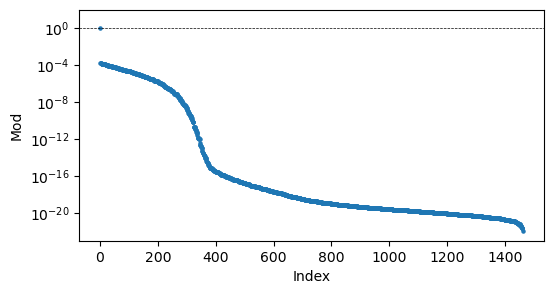

In [18]:
plot_mod_phis(phis) # if all but the largest eigenvalue are (strictly) inside the unit circle, the memorization is temporally stable

or simulate the network and check temporal stability after a while

In [19]:
from rsnn.spike_train.measure import multi_channel_correlation

In [20]:
for neuron in network.neurons:
    # perfect initialization
    neuron.firing_times = spike_trains[neuron.idx] - period
    neuron.firing_threshold = None

network.sim(0, 5*period, std_threshold=0.1, rng=rng) # the source of noise is the threshold noise

precision, recall = multi_channel_correlation([spike_trains[neuron.idx] for neuron in network.neurons], [neuron.firing_times for neuron in network.neurons], -period, period)
print(f"init\t| precision={precision:.3f} recall={recall:.3f}")
for i in range(5):
    precision, recall = multi_channel_correlation([spike_trains[neuron.idx] for neuron in network.neurons], [neuron.firing_times for neuron in network.neurons], i*period, period)
    print(f"cycle {i+1} | precision={precision:.3f} recall={recall:.3f}")

Network simulation:   0%|          | 0/25000 [00:00<?, ?it/s]

init	| precision=1.000 recall=1.000
cycle 1 | precision=0.956 recall=0.956
cycle 2 | precision=0.954 recall=0.954
cycle 3 | precision=0.954 recall=0.954
cycle 4 | precision=0.954 recall=0.954
cycle 5 | precision=0.955 recall=0.955


## Associative Recall

Memory recall in the network is associative.
When a group of neurons is prompted with a noisy version of the memorized spike trains, it is able to trigger recall at the level of the entire network, even in the presence of internal (threshold) noise.

In [21]:
from rsnn.spike_train.sampler import sample_jittered_spike_train

In [23]:
# reset the network for simulation
for neuron in network.neurons:
    neuron.firing_threshold = None
    neuron.firing_times = np.array([])

# prompt half of the neurons with a noisy version of the memorized spike trains for two simulation cycles
for neuron in network.neurons[:num_neurons//2]:
    neuron.firing_times = sample_jittered_spike_train((spike_trains[neuron.idx][None, :] + (np.arange(2) * period)[:, None]).flatten(), std_jitter=0.1, rng=rng)
network.sim(0, 2*period, std_threshold=0.1, sim_indices=range(num_neurons//2, num_neurons), rng=rng)
# then all neurons are autonomous for two more simulation cycles
network.sim(2*period, 2*period, std_threshold=0.1, rng=rng)

print(f"\t\t | prompted\t\t        | autonomous\t\t       | all")
for i in range(2):
    pr_p, re_p = multi_channel_correlation([spike_trains[neuron.idx] for neuron in network.neurons[:num_neurons//2]], [neuron.firing_times for neuron in network.neurons[:num_neurons//2]], i*period, period)
    pr_a, re_a = multi_channel_correlation([spike_trains[neuron.idx] for neuron in network.neurons[-num_neurons//2:]], [neuron.firing_times for neuron in network.neurons[-num_neurons//2:]], i*period, period)
    pr, re = multi_channel_correlation([spike_trains[neuron.idx] for neuron in network.neurons], [neuron.firing_times for neuron in network.neurons], i*period, period)
    print(f"cycle {i+1} (prompt) | precision={pr_p:.3f} recall={re_p:.3f} | precision={pr_a:.3f} recall={re_a:.3f} | precision={pr:.3f} recall={re:.3f} ")
for i in range(2, 4):
    pr_p, re_p = multi_channel_correlation([spike_trains[neuron.idx] for neuron in network.neurons[:num_neurons//2]], [neuron.firing_times for neuron in network.neurons[:num_neurons//2]], i*period, period)
    pr_a, re_a = multi_channel_correlation([spike_trains[neuron.idx] for neuron in network.neurons[-num_neurons//2:]], [neuron.firing_times for neuron in network.neurons[-num_neurons//2:]], i*period, period)
    pr, re = multi_channel_correlation([spike_trains[neuron.idx] for neuron in network.neurons], [neuron.firing_times for neuron in network.neurons], i*period, period)
    print(f"cycle {i+1} (prompt) | precision={pr_p:.3f} recall={re_p:.3f} | precision={pr_a:.3f} recall={re_a:.3f} | precision={pr:.3f} recall={re:.3f} ")

Network simulation:   0%|          | 0/10000 [00:00<?, ?it/s]

Network simulation:   0%|          | 0/10000 [00:00<?, ?it/s]

		 | prompted		        | autonomous		       | all
cycle 1 (prompt) | precision=0.851 recall=0.849 | precision=0.671 recall=0.385 | precision=0.751 recall=0.614 
cycle 2 (prompt) | precision=0.840 recall=0.840 | precision=0.833 recall=0.761 | precision=0.829 recall=0.794 
cycle 3 (prompt) | precision=0.951 recall=0.951 | precision=0.951 recall=0.951 | precision=0.951 recall=0.951 
cycle 4 (prompt) | precision=0.954 recall=0.954 | precision=0.955 recall=0.955 | precision=0.954 recall=0.954 
